In [82]:
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

from TFIM_generator import generate_TFIM_gates 
pi = np.pi

In [83]:
def create_hamiltonian(qubits, system, scale_factor, g=0, J=4, show_steps=False):
    assert(system.upper() == "TFIM" or system.upper() == "SPIN")
    assert(scale_factor<=2*pi)
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    if system.upper() == "TFIM":
        # construct the Hamiltonian
        # with Pauli Operators in Qiskit ^ represents a tensor product
        if show_steps: print("H = ", end='')
        for i in range(qubits-1):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i or j == i+1):
                    temp ^= Pauli('Z')
                else:
                    temp ^= Pauli('I')
            H += -temp.to_matrix()
            if show_steps: print("-"+str(temp)+" ", end='')
        for i in range(qubits):
            temp = Pauli('')
            for j in range(qubits):
                if (j == i):
                    temp ^= Pauli('X')
                else:
                    temp ^= Pauli('I')
            H += -g*temp.to_matrix()
            if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
        if show_steps: print("\n")
    elif system.upper() == "SPIN":
        assert(J!=0)
        def S(index, coupling):
            temp = Pauli('')
            for j in range(qubits):
                if j == index:
                    temp ^= Pauli(coupling)
                else:
                    temp ^= Pauli('I')
            return 1/2*temp.to_matrix()
        if show_steps: print("H = ", end='\n')
        for qubit in range(qubits-1):
            H += S(qubit, 'X')@S(qubit+1, 'X')
            H += S(qubit, 'Y')@S(qubit+1, 'Y')
            H += S(qubit, 'Z')@S(qubit+1, 'Z')
        H += S(qubits-1, 'X')@S(0, 'X')
        H += S(qubits-1, 'Y')@S(0, 'Y')
        H += S(qubits-1, 'Z')@S(0, 'Z')
        H *= J
        if show_steps: print(H)
    if show_steps:
        val, vec = np.linalg.eigh(H)
        print("Original eigenvalues:", val)
        print("Original eigenvectors:\n", vec)
    
    # scale eigenvalues of the Hamiltonian
    if show_steps: print("Norm =", np.linalg.norm(H, ord=2))
    H = scale_factor*H/np.linalg.norm(H, ord=2)
    # rotate matrix so that it will be positive definite (not nessary in this usecase)
    # H += pi*np.eye(2**qubits)

    if show_steps:
        val, vec = np.linalg.eigh(H)
        print("Scaled eigenvalues:", val)
        print("Scaled eigenvectors:\n", vec)
        min_eigenvalue = np.min(val)
        print("Lowest energy eigenvalue", min_eigenvalue); print()
    
    return H

def hadamard_test(controlled_U, statevector, W = 'Re', shots=100):
    aer_sim = AerSimulator()
    trans_qc = create_hadamard_test(aer_sim, controlled_U, statevector, W = W)
    counts = aer_sim.run(trans_qc, shots = shots).result().get_counts()
    return calculate_re(counts, shots)

def create_hadamard_test(backend, controlled_U, statevector, W = 'Re'):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(controlled_U.num_qubits-1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    qc.initialize(statevector, qr_eigenstate[:])
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    trans_qc = transpile(qc, backend)
    return trans_qc

def calculate_re(counts, shots):
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas

In [84]:
'''
particles: number of particles
Dt: time step
K: maximum number of iterations
backend: system to transpile circuits for
method: the method for creating the unitary operator; either QISKIT or F3C
'''
def generate_s_k(particles, system, scaling, Dt, K, g=0, J=4, shots=100, method = 'F3C'):
    assert(method[0].upper() == 'Q' or method[0].upper() == 'F')
    s_k = []
    if method[0].upper() == 'Q':
        ham = create_hamiltonian(particles, system, scaling, g=g, J=J)
    if method[0].upper() == 'F':
        gates = generate_TFIM_gates(particles, K, Dt, g, '../f3cpp')
    for i in range(K):
        if method[0].upper() == 'Q':
            mat = expm(1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = np.linalg.eigh(ham)
            statevector = vec[:,0]
        if method[0].upper() == 'F':
            controlled_U = gates[i]
            if g<0: statevector = Pauli('X'+'I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        s_k.append(hadamard_test(controlled_U, statevector, shots = shots))
    return s_k

'''
ham: system hamiltonian
Dt: time step
K: maximum number of iterations
backend: system to transpile circuits for
method: the method for creating the unitary operator; either QISKIT or F3C
'''
def transpile_s_k(particles, system, scaling, Dt, K, backend, g=0, J=4, method = 'F3C'):
    assert(method[0].upper() == 'Q' or method[0].upper() == 'F')
    trans_qcs = []
    if method[0].upper() == 'Q':
        ham = create_hamiltonian(particles, system, scaling, g=g, J=J)
    if method[0].upper() == 'F':
        gates = generate_TFIM_gates(particles, K, Dt, g, '../f3cpp')
    for i in range(K):
        if method[0].upper() == 'Q':
            mat = expm(1j*ham*Dt*i)
            controlled_U = UnitaryGate(mat).control(annotated="yes")
            _,vec = np.linalg.eigh(ham)
            statevector = vec[:,0]
        if method[0].upper() == 'F':
            controlled_U = gates[i]
            if g<0: statevector = Pauli('I' * particles).to_matrix
            else: statevector = [1/np.sqrt(2**particles)]*2**particles
        trans_qcs.append(create_hadamard_test(backend, controlled_U, statevector))
    return trans_qcs


'''
start: where to start reading the data from
k: number of columns
d: how much data per column
s_k: quantum data to create matrix
'''
def make_X(start, k, d, s_k):
    X = np.zeros((d, k))
    for i in range(len(X)):
        for j in range(len(X[i])):
            # print(i+j+start)
            X[i][j] = s_k[(i+j+start)%len(s_k)]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = np.linalg.svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    for l in range(len(sigma)):
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the singular value
            U[:,l] = 0   # remove the corresponding column
            V[l,:] = 0   # remove the corresponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    return U @ sigma_mat @ V

def check_convergence(data, order = 2):
    if len(data) <= order: return False
    temp = data
    zero = 0.001
    for _ in range(order):
        if abs(temp[-1]-temp[-2]) > zero:
            return False
        temp2 = []
        for i in range(len(temp)-1):
            temp2.append(temp[i+1]-temp[i])
        temp = temp2
    return True

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each iteration
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(s_k, Dt, noise_threshold, alpha = 1/2, est_E_0s = [], show_steps = False, order = 2): 
    K = int(2*pi/Dt) # maximum iterations
    if show_steps: print("Max iterations:", K)
    if show_steps: print("s_k:", s_k)
    k = -1
    while (True):
        k=k+1
        if k*Dt > 2*pi: break
        if show_steps: print("k =", k)
        d = math.floor(alpha*(k+1))
        if d < 1 or k < 1: continue
        X = make_X(0, k, d, s_k)
        if show_steps: print("X\n",X)
        Xprime = make_X(1, k, d, s_k)
        if show_steps: print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        if show_steps: print("X_sigma\n",X_sigma)
        A = Xprime @ np.linalg.pinv(X_sigma)
        if show_steps: print("A\n",A)  
        eigenvalues,_ = np.linalg.eig(A)
        if show_steps: print("eigenvalues\n", eigenvalues)
        eigenmax = max(eigenvalues, key=abs)
        if show_steps: print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        # if angle < 2*pi: angle+=2*pi
        if show_steps: print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        if show_steps: print("E_0 =", E_0)
        if k*Dt>1 and check_convergence(est_E_0s, order = order): break
    return E_0

In [ ]:
# SYSTEM PARAMETERS
particles          = 4
g                  = 4 # magnetic field strength (TFIM)
J                  = 4 # coupling strength (SPIN)
time_steps         = [.2]*25 # time steps to test use with ODMD
noise_threshold    = 0.01
shots              = 100
scaling            = 3*pi/4

# system OPTIONS: TFIM, SPIN
system             = 'TFIM'
# computation_type OPTIONS: Simulation, Hardware
computation_type   = 'S'
# data_source OPTIONS: Generation (Only useable with Simulation), Files, Job (Only Usable with Hardware)
data_source        = 'F'
# method_for_model OPTIONS: F3C (Only for TFIM), Qiskit
method_for_model   = 'F'

# H = create_hamiltonian(particles, system, scaling, g=1, show_steps=True)

In [86]:
# PREPROCESSING

# parameter checking (if theres an error change system parameters)
assert(computation_type[0].upper() == 'S' or computation_type[0].upper() == 'H')
assert(not method_for_model[0].upper()=="F" or system=="TFIM")
assert(data_source[0].upper() == 'G' or data_source[0].upper() == 'F' or data_source[0].upper() == 'J')
assert(not (computation_type[0].upper() == 'S' and data_source[0].upper() == 'J'))
assert(not (computation_type[0].upper() == 'H' and data_source[0].upper() == 'G'))

# time_steps = sum(time_steps, [])

Ks = []
for time_step in time_steps:
    K = 2*int(2*pi/time_step)+1
    if K < 200: Ks.append(K)
    else: Ks.append(100)

# backend setup
if computation_type[0].upper() == 'H' or data_source[0].upper() == 'J':
    api_token = input("Enter API Token:")
    from qiskit_ibm_runtime import QiskitRuntimeService as QRS
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
else:
    backend = AerSimulator()
sampler = Sampler(backend)

# define a system for naming files
def make_filename(system, computation_type, method_for_model, particles, time_step=-1):
    string = "sys="+system+"_type="+computation_type[0].upper()+"_m="+method_for_model[0].upper()+"_n="+str(particles)
    if system=="TFIM": string+="_g="+str(g)
    elif system=="SPIN": string+="_J="+str(J)
    if method_for_model[0].upper() == "Q": string+="_s="+str(scaling)
    if time_step != -1: string+="_Dt="+str(time_step)+".qpy"
    return string

In [ ]:
s_ks = []

# save data when using files
if data_source[0].upper() == 'F':
    from qiskit import qpy
    import os

    def empty(filename):
        try:
            return os.path.getsize(filename) == 0
        except FileNotFoundError:
            return True
        
    for i in range(len(time_steps)):
        time_step = time_steps[i]
        K = Ks[i]
        filename = "Transpiled_Circuits/"+make_filename(system, computation_type, method_for_model, particles, time_step=time_step)
        if empty(filename):
            print("Creating file for Dt =", time_step)
            trans_qcs = transpile_s_k(particles, system, scaling, time_step, K, backend, g=g, J=J, method=method_for_model)
            with open(filename, "wb") as file:
                qpy.dump(trans_qcs, file)
        else:
            print("File found for Dt =", time_step)
    print()

# load/generate s_k data
if data_source[0].upper() == 'F':
    trans_qcs = []
    for time_step in time_steps:
        print("Loading data from file for Dt =", time_step)
        filename = "Transpiled_Circuits/"+make_filename(system, computation_type, method_for_model, particles, time_step=time_step)
        with open(filename, 'rb') as file:
            qcs = qpy.load(file)
            trans_qcs.append(qcs)
    print()
    trans_qcs = sum(trans_qcs, []) # flatten list
    if computation_type[0].upper() == 'H': print("Sending Job")
    if computation_type[0].upper() == 'S': print("Running Circuits")
    results = sampler.run(trans_qcs, shots = shots).result() # all time steps are put into a single job
    if computation_type[0].upper() == 'H': print("Recieved Data")
    print()
elif data_source[0].upper() == 'J':
    job_id = input("Enter Job ID:")
    job = service.job(job_id)
    print("Loading data from job")
    results = job.result()
    print()


# construct s_k
for i in range(len(time_steps)):
    time_step = time_steps[i]
    if data_source[0].upper() == 'G':
        print("Generating Data for Dt =", time_step)
        K = Ks[i]
        s_ks.append(generate_s_k(particles, system, scaling, time_step, K, shots = shots, method=method_for_model, g=g, J=J))
    else:
        print("Calculating s_k for time step:", time_step)
        start = sum(Ks[0:i])
        result = results[start:start+Ks[i]] # seperate the data needed for this iteration
        s_k = []
        for i in range(len(result)):
            raw_data = result[i].data
            cbit = list(raw_data.keys())[0]
            s_k.append(calculate_re(raw_data[cbit].get_counts(), shots))
        s_ks.append(s_k)



Creating file for Dt = 0.2
********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 63 , dt = 0.2

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1
* timestep 2: hx = 4, Jz = 1
* timestep 3: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 4: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 5: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 6: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 7: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 8: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 9: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 10: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 11: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 12: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 13: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
*

In [ ]:
trials = []
results = []
for i in range(len(time_steps)):
    time_step = time_steps[i]
    print("Using data from time step:", time_step)
    est_E_0s = []
    result = ODMD(s_ks[i], time_step, noise_threshold, est_E_0s = est_E_0s) 
    print("Calculated Energy:", result)
    results.append(result)
    trials.append(est_E_0s)


Using data from time step: 0.5
Calculated Energy: -4.141793084351132
Using data from time step: 0.5
Calculated Energy: -4.124849337841664
Using data from time step: 0.5
Calculated Energy: -4.1409828599699905
Using data from time step: 0.5
Calculated Energy: -6.283185307179586
Using data from time step: 0.5
Calculated Energy: -1.8744721919014034
Using data from time step: 0.5
Calculated Energy: -4.130127236731648
Using data from time step: 0.5
Calculated Energy: -4.125682243788904
Using data from time step: 0.5
Calculated Energy: -4.1206905920566
Using data from time step: 0.5
Calculated Energy: -4.144904642171078
Using data from time step: 0.5
Calculated Energy: -4.1379701148076515
Using data from time step: 0.5
Calculated Energy: -4.107349695040484
Using data from time step: 0.5
Calculated Energy: -4.141446479237452
Using data from time step: 0.5
Calculated Energy: -4.124919737585933
Using data from time step: 0.5
Calculated Energy: -1.9448299364420338
Using data from time step: 0.5
C

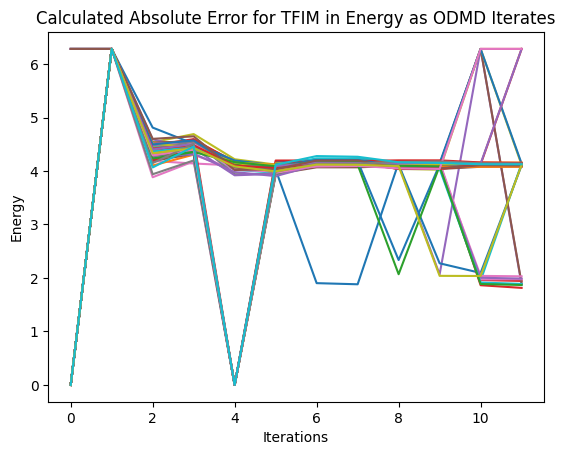

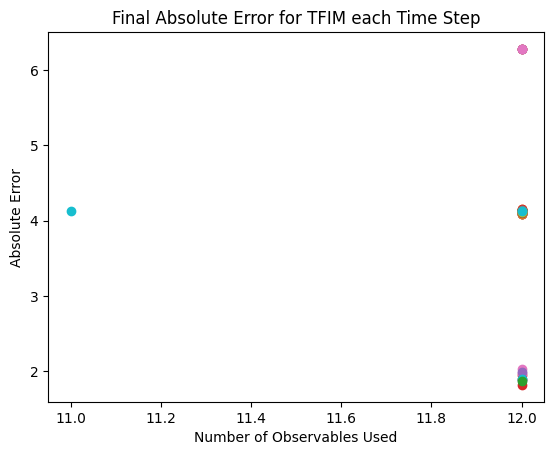

In [ ]:
if method_for_model[0].upper() == 'Q': real_E_0 = -scaling
else: real_E_0 = 0

for i in range(len(trials)):
    err = [abs(w-real_E_0) for w in trials[i]]
    # plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], err, label = 'Dt = '+str(time_steps[i]))
    plt.plot(err, label = 'Dt = '+str(time_steps[i]))
plt.title("Calculated Absolute Error for "+system+" in Energy as ODMD Iterates")
plt.ylabel("Energy")
plt.xlabel("Iterations")
# plt.legend()
# plt.xlim([0,100])
# plt.ylim([0,.5])
if method_for_model[0].upper() == 'Q': plt.yscale('log')
plt.savefig("Graphs/"+make_filename(system, computation_type, method_for_model, particles)+"_Abs_Error.png")
plt.show()

plt.title("Final Absolute Error for "+system+" each Time Step")
plt.xlabel("Number of Observables Used")
plt.ylabel("Absolute Error")
if method_for_model[0].upper() == 'Q': plt.yscale('log')
observables = [len(w) for w in trials]
for i in range(len(results)):
    plt.scatter([observables[i]], [abs(real_E_0-results[i])], label = 'Dt = '+str(time_steps[i]))
plt.savefig("Graphs/"+make_filename(system, computation_type, method_for_model, particles)+"_Final_Error.png")
# plt.legend()
plt.show()

In [ ]:
print(len(results))
print(results)
        

50
[-4.141793084351132, -4.124849337841664, -4.1409828599699905, -6.283185307179586, -1.8744721919014034, -4.130127236731648, -4.125682243788904, -4.1206905920566, -4.144904642171078, -4.1379701148076515, -4.107349695040484, -4.141446479237452, -4.124919737585933, -1.9448299364420338, -4.126488305687539, -1.8987292904229434, -2.0305719534215223, -4.132074076349977, -4.113926949013932, -4.11244013725731, -4.139091348323489, -4.12524263488511, -4.136451703903739, -1.8147899248446653, -4.088930475205474, -4.086129522917663, -1.9770886491612099, -4.124653170583671, -4.128058402270574, -4.1302522908695005, -4.134240407700055, -4.158220491958181, -4.117038725580554, -4.151547432354161, -1.988312187619853, -4.087655918722471, -4.114199531780378, -4.1343599615053455, -4.11772646097851, -1.8886623221117516, -4.121837401090686, -4.081288775207867, -1.8686050320359608, -6.283185307179586, -6.283185307179586, -4.103126012967927, -6.283185307179586, -4.138399847977091, -4.115587763406298, -4.125825